In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import wfdb

# fixed random seed
np.random.seed(0)

from utils import computeCO
from controlProblem import solveNOC

## 1 - Load data

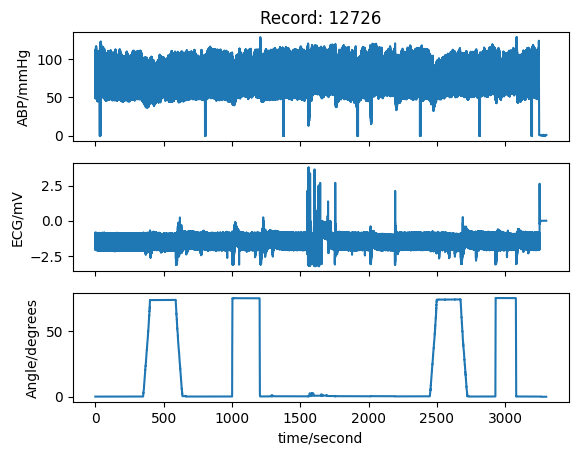

In [2]:
patientNum = 12726
dataDir = f"data/physionet.org/files/prcp/1.0.0/{patientNum}"
record = wfdb.rdrecord(dataDir)

wfdb.plot_wfdb(record)

In [3]:
fs = record.fs

bpRaw = record.p_signal[:,0]
tiltAngleRaw = record.p_signal[:,2]
time = np.arange(0, bpRaw.size) / fs

In [4]:
sex = record.comments[0].split(" ")[4]
height = float(record.comments[0].split(" ")[-4])
weight = float(record.comments[0].split(" ")[-1])
sex, height, weight

('M', 170.0, 64.0)

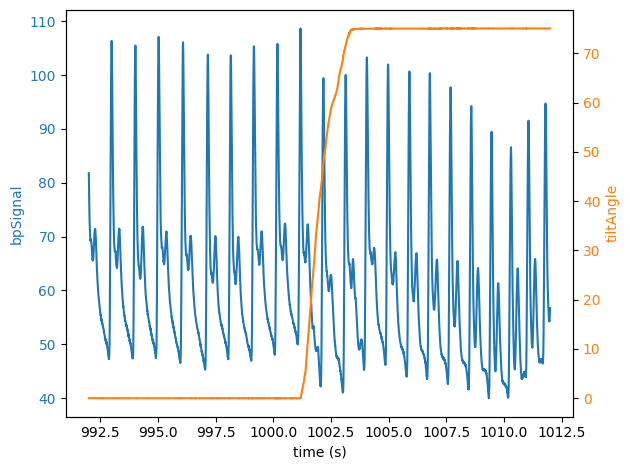

In [5]:
startTime = 992 # in seconds
endTime = 1012 # in seconds

startIdx = startTime * fs
endIdx = endTime * fs

bpSignal = bpRaw[startIdx:endIdx]
tiltAngle = tiltAngleRaw[startIdx:endIdx]
timeWindow = time[startIdx:endIdx]

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('bpSignal', color=color)
ax1.plot(timeWindow, bpSignal, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('tiltAngle', color=color)  
ax2.plot(timeWindow, tiltAngle, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()


## 2 - Optimal control

In [6]:
# downsample to time resolution of NOC problem
h = 0.01 # in seconds

# 250 Hz --> 10Hz: do decimate by 5 twice
bpDownsampleInter = sp.signal.decimate(bpSignal, 5)
bpDownsample = sp.signal.decimate(bpDownsampleInter, 5)

tiltAngleDownsampleInter = sp.signal.decimate(tiltAngle, 5)
tiltAngleDownsample = sp.signal.decimate(tiltAngleDownsampleInter, 5)

timeDownsample = np.arange(0, bpDownsample.size) * h

In [7]:
# (Cau, Cal, Cvu, Cvl, Ral, Ralp, Rvl)
RCVals = (1.7, 0.26, 51, 4.3, 0.15, 7.1, 0.028)

#some other constants (Hoyean)
# u0_lb = 0.62
# u0_ub = 1.0
# u1_lb = 81
# u1_ub = 99
# x_init = np.zeros(4)

In [8]:
Qd = computeCO(weight, height, sex)
x0, x1, x2, x3, u0, u1 = solveNOC(bpDownsample, RCVals, Qd, h)

# 3 - Visualize results

<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
C:\Users\karin\AppData\Local\Temp\ipykernel_4024\3174695723.py:34: SyntaxWarning: invalid escape sequence '\d'
  axTiltAngle.set_ylabel('Tilt angle ($\degree$)', color='tab:orange')


(100, 4) (99, 2)


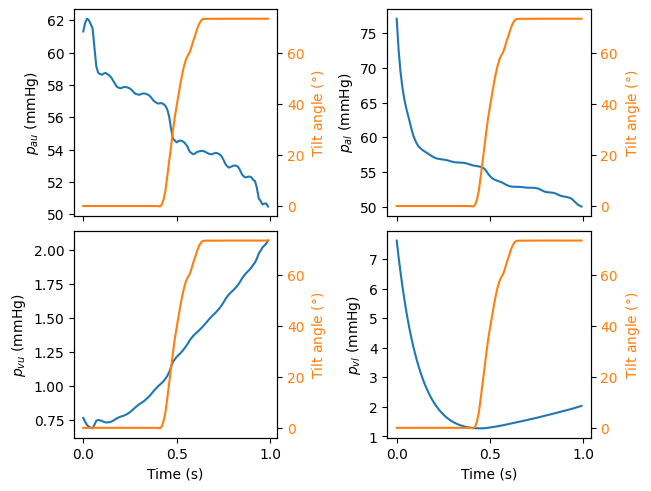

In [ ]:
# x_cvx = cp.Variable((N+1, 4)) # pau, pal, pvu, pvl
# u_cvx = cp.Variable((N, 2)) # Raup, Q

# PLOT STATES
x = np.vstack((x0, x1, x2, x3)).T
u = np.vstack((u0, u1)).T
# u = u0

# print(x.shape, u.shape)
# x = np.zeros((bpDownsample.size + 1, 4))
# u = np.zeros((bpDownsample.size, 2))

f, axs = plt.subplots(2, 2, sharex = True, constrained_layout=True)
timeStates = np.arange(0, bpDownsample.size) * h

axs[0,0].plot(timeStates, x[:,0])
axs[0,0].set_ylabel('$p_{au}$ (mmHg)')

axs[0,1].plot(timeStates, x[:,1])
axs[0,1].set_ylabel('$p_{al}$ (mmHg)')

axs[1,0].plot(timeStates, x[:,2])
axs[1,0].set_ylabel('$p_{vu}$ (mmHg)')
axs[1,0].set_xlabel('Time (s)')

axs[1,1].plot(timeStates, x[:,3])
axs[1,1].set_ylabel('$p_{vl}$ (mmHg)')
axs[1,1].set_xlabel('Time (s)')

for i in range(2):
    for j in range(2):
        axTiltAngle = axs[i,j].twinx()
        axTiltAngle.plot(timeStates, tiltAngleDownsample, color='tab:orange')
        axTiltAngle.set_ylabel('Tilt angle ($\degree$)', color='tab:orange')
        axTiltAngle.tick_params(axis='y', labelcolor='tab:orange')

plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
C:\Users\karin\AppData\Local\Temp\ipykernel_4024\2955180341.py:16: SyntaxWarning: invalid escape sequence '\d'
  axTiltAngle.set_ylabel('Tilt angle ($\degree$)', color='tab:orange')


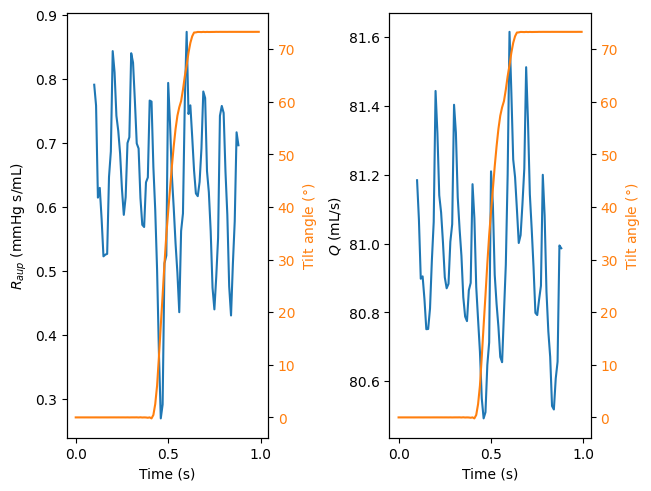

In [ ]:
# PLOT CONTROLS

f, axs = plt.subplots(1, 2, sharex=True, constrained_layout=True)

axs[0].plot(timeStates[10:-11], u[10:-10,0])
axs[0].set_ylabel('$R_{aup}$ (mmHg s/mL)')
axs[0].set_xlabel('Time (s)')

axs[1].plot(timeStates[10:-11], u[10:-10,1])
axs[1].set_ylabel('$Q$ (mL/s)')
axs[1].set_xlabel('Time (s)')

for i in range(2):
    axTiltAngle = axs[i].twinx()
    axTiltAngle.plot(timeStates, tiltAngleDownsample, color='tab:orange')
    axTiltAngle.set_ylabel('Tilt angle ($\degree$)', color='tab:orange')
    axTiltAngle.tick_params(axis='y', labelcolor='tab:orange')